# ロジスティック回帰

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

## ロジスティック回帰モデル

識別モデルとして$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$を用いる。

ただし、$\sigma(\cdot)$はシグモイド関数であり、$\sigma(h) = \frac{1}{1 + \exp{(-h)}}$で定義される。

また、陽には書かないが、$\boldsymbol{x}$には定数項のための$1$という要素があることを仮定する。

訓練データ <br>
$\displaystyle X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ..., \boldsymbol{x}_{n}]^{\mathrm{T}}, \boldsymbol{y} = [y_{1}, y_{2}, ..., y_{n}]^{\mathrm{T}} (y_{i} = \{0, 1\})$ 
<br>
に対して尤度関数$L$は以下のように書ける。
<br>

$\displaystyle L(\boldsymbol{w}) = \prod_{i=1}^{n} p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})^{y_{i}} (1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))^{1 - y_{i}}$


負の対数尤度関数は <br>
$\displaystyle - \log{L(\boldsymbol{w})} = - \sum_{i=1}^{n} \left[ y_{i} \log{p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})} + (1 - y_{i}) \log{(1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))} \right]$ <br>
のように書ける。 これを最小化する$\boldsymbol{w}$を求める。<br>
<br>

$\displaystyle \frac{d \sigma(h)}{d h} = \sigma(h)(1 - \sigma(h))$と書けることを考慮し、負の対数尤度関数を$\boldsymbol{w}$で偏微分すると、
<br>

$\displaystyle \begin{aligned}
\frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})}) &=& -\sum_{i=1}^{n} \left[ y_{i} (1 - \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i})) - (1 - y_{i}) \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) \right] \boldsymbol{x}_{i}  \cr
&=& \sum_{i=1}^{n} \left( \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) - y_{i} ) \right)\boldsymbol{x}_{i}
\end{aligned}$

<br>

この式が$0$となる$\boldsymbol{w}$は解析的に求められないので、今回は$-\log{L(\boldsymbol{w})}$の最小化問題を最急降下法を用いて解く。
<br>

最急降下法では学習率を$\eta$とすると、以下の式で$\boldsymbol{w}$を更新する。
<br>

$\displaystyle \boldsymbol{w} \leftarrow \boldsymbol{w} - \eta \frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})})$

# データ作成　ランダムデータ

In [57]:
n_sample = 100
harf_n_sample = 50
var = .2

def gen_data(n_sample, harf_n_sample):
    x0 = np.random.normal(size=n_sample).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=n_sample).reshape(-1, 2) + 1.
    x_train = np.concatenate([x0, x1])
    y_train = np.concatenate([np.zeros(harf_n_sample), np.ones(harf_n_sample)]).astype(np.int)
    return x_train, y_train

def plt_data(x_train, y_train):
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.legend()

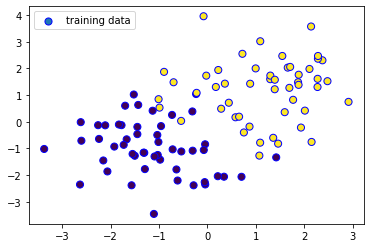

In [58]:
#データ作成
x_train, y_train = gen_data(n_sample, harf_n_sample)
#データ表示
plt_data(x_train, y_train)

## データ作成 タイタニックデータ

タイタニックの乗客データを利用しロジスティック回帰モデルを作成
特徴量抽出をしてみる

年齢が30歳で男の乗客は生き残れるか？

In [4]:
# titanic data csvファイルの読み込み
titanic_df = pd.read_csv('./data/titanic_train.csv')
# ファイルの先頭部を表示し、データセットを確認する
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
#nullを含んでいる行を表示
titanic_df[titanic_df.isnull().any(1)].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Pclass_Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,4
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,4
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,2
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S,1,4
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1,4
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,0,3


In [13]:
#Ageカラムのnullを中央値で補完

titanic_df['AgeFill'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())

#再度nullを含んでいる行を表示 (Ageのnullは補完されている)
titanic_df[titanic_df.isnull().any(1)]

#titanic_df.dtypes

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Pclass_Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,4,22.000000
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3,26.000000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,4,35.000000
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,4,29.699118
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,4,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,1,4,25.000000
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0,3,39.000000
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,3,27.000000
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,3,29.699118


## ラベルエンコーディング

In [163]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

#変換するエンコーダの作成
label_encoder = enc.fit(titanic_df[["Sex"]])
# カラムの要素を取得
print('Categorical classes:',label_encoder.classes_)
# transform()で数値へ変換
integer_classes = label_encoder.transform(label_encoder.classes_)
print('Integer classes:',integer_classes)
# ラベルエンコーディングされたことを確認
t = label_encoder.transform(titanic_df[["Sex"]])
print(t)

Categorical classes: ['female' 'male']
Integer classes: [0 1]
[1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1
 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0
 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1
 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0
 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0
 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## One Hot Encoding

In [164]:
from sklearn.preprocessing import OneHotEncoder

titanic = titanic_df[["Pclass"]]
titanic  = titanic[["Pclass"]] # Pclassのカラム（列）のみを取得

# OneHotEncoderのsparse引数はデフォルトではTrueだが、
# Trueにするとscipyモジュールのcsr_matrixの型になる。
# csr_matrixはその後の扱いが厄介なので、Falseにして2次元のnumpy.ndarrayにする。
enc = OneHotEncoder(sparse= False)
# fit()とtransform()により、ワンホットエンコーディングを行う
one_hot_encoder = enc.fit(titanic)
# 変数new_featuresにはOne-Hot、つまり1つだけ1で、それ以外は0のベクトル（行列）が代入されています
new_features = one_hot_encoder.transform(titanic) # transformによって返ってくるデータ型はnumpy.ndarrayです。
# ※ fit()とtransform()をまとめて行うfit_transform()もあります。
#カラムの生成
columns = []
cols = ["Pclass"]
# enumerate()を使うと、インデックス番号, 要素の順に取得できます。
# ループ内変数iにはインデックス番号が、ループ内変数cには要素が代入されています。
for i,c in enumerate(titanic[cols]):
    columns += [f'{v}' for v in one_hot_encoder.categories_[i]]
    
# Pandasのデータフレーム型に変換
one_hot_df = pd.DataFrame(new_features , columns=columns)
# 先頭から5件取得
one_hot_df.head()

,1,2,3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [165]:
#運賃だけのリストを作成
x_train2 = titanic_df.loc[:,["AgeFill","Sex"]].values
#生死フラグのみのリストを作成
y_train2 = titanic_df.loc[:,"Survived"].values

## 学習（ランダムデータ）

# Numpy実装

In [77]:
def add_one(x):
    return np.concatenate([np.ones(len(x))[:,None], x], axis=1)

In [87]:
def sigmoid(x):
    sig_r = 34.538776394910684
    condlist = [x < -sig_r, (x >= -sig_r) & (x < sig_r), x >= sig_r]
    funclist = [1e-15, lambda a: 1.0 / (1.0 + np.exp(-a)), 1.0 - 1e-15]
    return np.piecewise(x, condlist, funclist)

def sgd(X_train, Y_train,max_iter, eta):
    w = np.zeros(X_train.shape[1])
    for _ in range(max_iter):
        w_prev = np.copy(w)
        sigma = sigmoid(np.dot(X_train, w))
        grad = np.dot(X_train.T, (sigma - Y_train))
        w -= eta * grad
        if np.allclose(w, w_prev):
            return w
    return w
X_train = add_one(x_train)
max_iter=100
eta = 0.01
w = sgd(X_train,y_train, max_iter, eta)
print(w)

[0.334296   2.54051419 2.31720166]


## 予測（ランダムデータ）

入力に対して、$y=1$である確率を出力する。よって

$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$の値が

$0.5$より大きければ1に、小さければ0に分類する。

In [88]:
xx0, xx1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

In [89]:
X_test = add_one(xx)
proba = sigmoid(np.dot(X_test, w))
y_pred = (proba > 0.5).astype(np.int)

In [90]:
print(x_train)

[[-0.0453801  -2.34942278]
 [-2.25634168 -0.12700472]
 [-0.95716761 -0.16087448]
 [-1.77270945 -0.12643723]
 [ 0.34198347 -2.05875883]
 [ 0.21383949 -2.04034881]
 [-1.92183178 -0.9292404 ]
 [-2.06408109 -1.8615389 ]
 [-1.10491993 -3.4540674 ]
 [-0.53875468 -1.11217466]
 [-0.30467755 -1.0834259 ]
 [ 0.70302918 -2.06218786]
 [-1.69808373  0.60306747]
 [-0.0479832  -0.84354966]
 [-1.4283011   0.63228636]
 [-0.97599028 -1.41973636]
 [-1.66686296 -0.65725746]
 [-2.60118472 -0.70968006]
 [-2.62952053 -2.35226086]
 [-1.49942542 -1.27371883]
 [-2.14890466 -1.45035194]
 [-0.71790052 -1.03306311]
 [-1.01134199 -0.75793518]
 [-3.36917341 -1.01872922]
 [-0.05601258 -2.26164652]
 [-0.73020903  0.25804025]
 [-1.30358584 -1.16151973]
 [-1.44604551 -0.46287722]
 [-1.29069645 -1.77367217]
 [-2.61434216 -0.01346419]
 [-1.03425118 -0.4947529 ]
 [-1.82675576 -0.1024746 ]
 [-1.13085552  0.41488001]
 [-0.63960008 -1.78680944]
 [-0.31100334  0.38790468]
 [-0.23383517  1.04117034]
 [-1.5448952  -1.20585113]
 

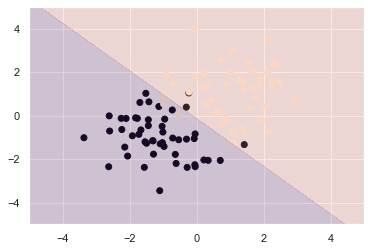

In [91]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))

# Sklearn実装

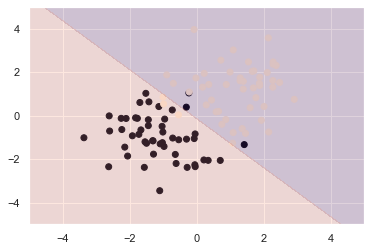

In [92]:
#sklearn実装

from sklearn.linear_model import LogisticRegression
model=LogisticRegression(fit_intercept=True)
model.fit(x_train, y_train)
proba = model.predict_proba(xx)
y_pred = (proba > 0.5).astype(np.int)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba[:, 0].reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))

## 学習（タイタニックデータ）

In [123]:
X_train2 = add_one(x_train2)
max_iter2=891
eta = 0.01
w2 = sgd(X_train2, y_train2, max_iter2, eta)
print(w2)

[ 177.24356077   11.47351949 -633.93310634]


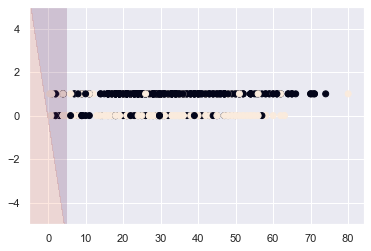

In [124]:
plt.scatter(x_train2[:, 0], x_train2[:, 1], c=y_train2)
xx02, xx12 = np.meshgrid(np.linspace(-5, 5, 891), np.linspace(-5, 5, 891))
xx2 = np.array([xx02, xx12]).reshape(2, -1).T
proba2 = model.predict_proba(xx2)
y_pred2 = (proba2 > 0.5).astype(np.int)
plt.contourf(xx02, xx12, proba2[:, 0].reshape(891, 891), alpha=0.2, levels=np.linspace(0, 1, 3))

## 予測
### SKLEARN

In [26]:
#運賃だけのリストを作成
data1 = titanic_df.loc[:, ["Fare"]].values
#生死フラグのみのリストを作成
label1 =  titanic_df.loc[:,["Survived"]].values
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(data1, label1)
model.predict([[61]])

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0])

In [158]:
X_test_value = model.decision_function(data1) 
# # 決定関数値（絶対値が大きいほど識別境界から離れている）
# X_test_value = model.decision_function(X_test) 
# # 決定関数値をシグモイド関数で確率に変換
# X_test_prob = normal_sigmoid(X_test_value) 
print (model.intercept_)
print (model.coef_)

[-0.94131796]
[[0.01519666]]


No handles with labels found to put in legend.


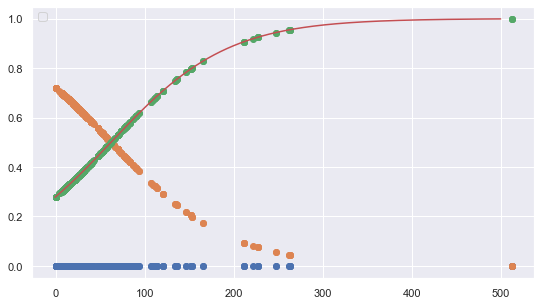

In [159]:
w_0 = model.intercept_[0]
w_1 = model.coef_[0,0]

# def normal_sigmoid(x):
#     return 1 / (1+np.exp(-x))

def sigmoid(x):
    return 1 / (1+np.exp(-(w_1*x+w_0)))

x_range = np.linspace(-1, 500, 3000)

plt.figure(figsize=(9,5))
#plt.xkcd()
plt.legend(loc=2)


# plt.ylim(-0.1, 1.1)
# plt.xlim(-10, 10)

# plt.plot([-10,10],[0,0], "k", lw=1)
# plt.plot([0,0],[-1,1.5], "k", lw=1)
plt.plot(data1,np.zeros(len(data1)), 'o')
plt.plot(data1,model.predict_proba(data1), 'o')
plt.plot(x_range,sigmoid(x_range), '-')
#plt.plot(x_range, normal_sigmoid(x_range), '-')
#

<h1>1. ロジスティック回帰</h1>
<h3>実装(2変数から生死を判別)</h3>

In [5]:
#AgeFillの欠損値を埋めたので
#titanic_df = titanic_df.drop(['Age'], axis=1)
titanic_df['Gender'] = titanic_df['Sex'].map({'female': 0, 'male': 1}).astype(int)
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


In [6]:
titanic_df['Pclass_Gender'] = titanic_df['Pclass'] + titanic_df['Gender']
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Pclass_Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,4


In [7]:
titanic_df2 = titanic_df.drop(['Pclass', 'Sex', 'Gender','Age'], axis=1)
titanic_df2.head()

,PassengerId,Survived,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_Gender
0,1,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,S,4
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,C,1
2,3,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,C123,S,1
4,5,0,"Allen, Mr. William Henry",0,0,373450,8.0500,NaN,S,4


In [171]:
# 重要だよ！！！
# 境界線の式
#   w_1・x + w_2・y + w_0 = 0
#   ⇒ y = (-w_1・x - w_0) / w_2
 
# # 境界線 プロット
# plt.plot([-2,2], map(lambda x: (-w_1 * x - w_0)/w_2, [-2,2]))
 
# # データを重ねる
# plt.scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='red', marker='x', label='train 0')
# plt.scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='blue', marker='x', label='train 1')
# plt.scatter(X_test_std[y_test==0, 0], X_test_std[y_test==0, 1], c='red', marker='o', s=60, label='test 0')
# plt.scatter(X_test_std[y_test==1, 0], X_test_std[y_test==1, 1], c='blue', marker='o', s=60, label='test 1')

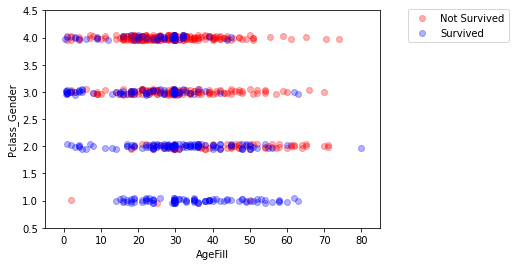

In [14]:
np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = titanic_df[titanic_df["Survived"]==0].index
index_notsurvived = titanic_df[titanic_df["Survived"]==1].index

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))

In [18]:
#運賃だけのリストを作成
data2 = titanic_df.loc[:, ["Fare", "Pclass_Gender"]].values
data2

array([[ 7.25  ,  4.    ],
       [71.2833,  1.    ],
       [ 7.925 ,  3.    ],
       ...,
       [23.45  ,  3.    ],
       [30.    ,  2.    ],
       [ 7.75  ,  4.    ]])

In [19]:
#生死フラグのみのリストを作成
from sklearn.linear_model import LogisticRegression
label2 = titanic_df.loc[:,["Survived"]].values
model2 = LogisticRegression()
model2.fit(data2, label2)
print (model2.intercept_)
print (model2.coef_)

[3.42539711]
[[-0.00221662 -1.33656736]]


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
model2.predict([[10,1]])

array([1])

In [21]:
model2.predict_proba([[10,1]])

array([[0.11237942, 0.88762058]])

In [22]:
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Pclass_Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,4,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3,26.0


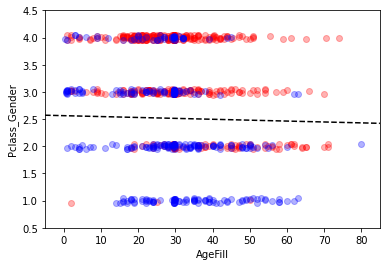

In [23]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = model2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.5)

sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)

ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
#fig.colorbar(contour)

x1 = xmin
x2 = xmax
y1 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmin)/model2.coef_[0][1]
y2 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmax)/model2.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

<h1>2. モデル評価</h1>
<h3>混同行列とクロスバリデーション</h3>

In [24]:
from sklearn.model_selection import train_test_split

In [27]:
traindata1, testdata1, trainlabel1, testlabel1 = train_test_split(data1, label1, test_size=0.2)
traindata1.shape
trainlabel1.shape

(712, 1)

In [28]:
traindata2, testdata2, trainlabel2, testlabel2 = train_test_split(data2, label2, test_size=0.2)
traindata2.shape
trainlabel2.shape
#本来は同じデータセットを分割しなければいけない。(簡易的に別々に分割している。)

(712, 1)

In [29]:
data = titanic_df.loc[:, ].values
label =  titanic_df.loc[:,["Survived"]].values
traindata, testdata, trainlabel, testlabel = train_test_split(data, label, test_size=0.2)
traindata.shape
trainlabel.shape

(712, 1)

In [30]:
eval_model1=LogisticRegression()
eval_model2=LogisticRegression()
#eval_model=LogisticRegression()

In [31]:
predictor_eval1=eval_model1.fit(traindata1, trainlabel1).predict(testdata1)
predictor_eval2=eval_model2.fit(traindata2, trainlabel2).predict(testdata2)
#predictor_eval=eval_model.fit(traindata, trainlabel).predict(testdata)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
eval_model1.score(traindata1, trainlabel1)

0.6699438202247191

In [33]:
eval_model1.score(testdata1,testlabel1)

0.6368715083798883

In [34]:
eval_model2.score(traindata2, trainlabel2)

0.7542134831460674

In [35]:
eval_model2.score(testdata2,testlabel2)

0.7597765363128491

In [36]:
from sklearn import metrics
print(metrics.classification_report(testlabel1, predictor_eval1))
print(metrics.classification_report(testlabel2, predictor_eval2))

              precision    recall  f1-score   support

           0       0.63      0.94      0.75       106
           1       0.70      0.19      0.30        73

    accuracy                           0.64       179
   macro avg       0.66      0.57      0.53       179
weighted avg       0.66      0.64      0.57       179

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.63      0.55      0.59        56

    accuracy                           0.76       179
   macro avg       0.72      0.70      0.71       179
weighted avg       0.75      0.76      0.76       179



In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix1=confusion_matrix(testlabel1, predictor_eval1)
confusion_matrix2=confusion_matrix(testlabel2, predictor_eval2)

In [38]:
confusion_matrix1

array([[100,   6],
       [ 59,  14]])

In [39]:
confusion_matrix2

array([[105,  18],
       [ 25,  31]])

<AxesSubplot:>

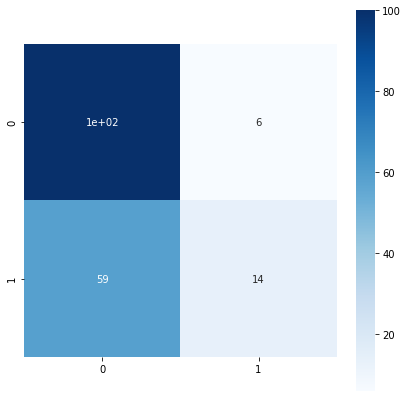

In [41]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix1,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

<AxesSubplot:>

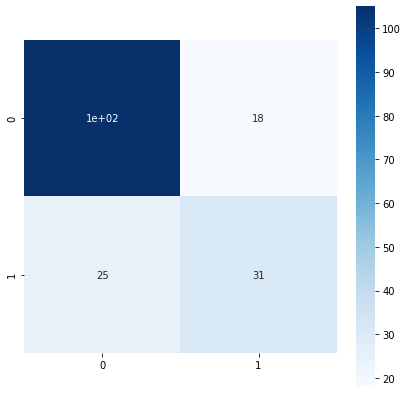

In [42]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix2,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


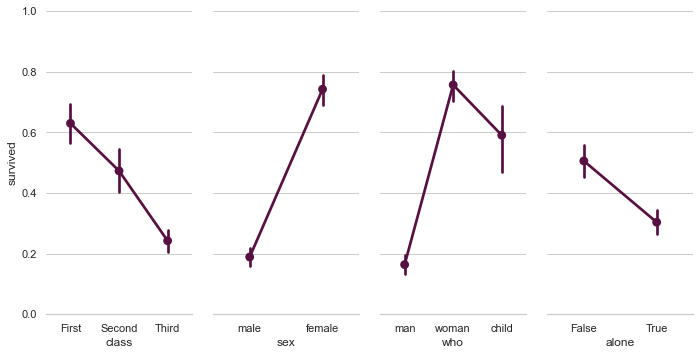

In [43]:
#Paired categorical plots

import seaborn as sns
sns.set(style="whitegrid")

# Load the example Titanic dataset
titanic = sns.load_dataset("titanic")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(titanic, y_vars="survived",
                 x_vars=["class", "sex", "who", "alone"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

plt.show()

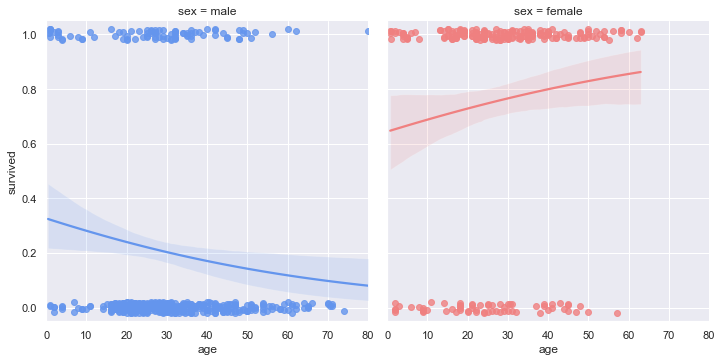

In [44]:
#Faceted logistic regression

import seaborn as sns
sns.set(style="darkgrid")

# Load the example titanic dataset
df = sns.load_dataset("titanic")

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))
plt.show()